#  导入依赖

In [102]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings

warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore")

# 定义要处理的模型(YOLOv8n目标检测模型)

In [103]:
yolo = YOLO(model='./models/yolov8n.pt')
yolo = yolo.cuda()

选择要处理的层

In [104]:
yolo.info(detailed=True)
yolo_model = yolo.model
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
yolo_model = yolo_model.to(device)

layer                                    name                type  gradient  parameters               shape        mu     sigma
    0                     model.0.conv.weight              Conv2d     False         432       [16, 3, 3, 3]  -0.00279     0.152        float32
    1                       model.0.bn.weight         BatchNorm2d     False          16                [16]      2.97      1.86        float32
    1                         model.0.bn.bias         BatchNorm2d     False          16                [16]     0.249      4.17        float32
    2                             model.0.act                SiLU     False           0                  []         -         -              -
    3                     model.1.conv.weight              Conv2d     False        4608      [32, 16, 3, 3]  -0.00012     0.063        float32
    4                       model.1.bn.weight         BatchNorm2d     False          32                [32]      5.02      1.12        float32
    4         

In [105]:
yolo_model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

选择要进行CAM操作的目标层,暂时只检查backbone

In [106]:
yolo_nn = yolo_model.model
layer_map = {
    # 如果要选择其他c2f输出,只需要更改这个字典
    "backbone_c2f1": 2,
    "backbone_c2f2": 4,
    "backbone_c2f3": 6,
    "backbone_c2f4": 8, 
    "backbone_c2f5": 12	
}

backbone_layers = {layer: yolo_nn[idx] for layer, idx in layer_map.items()}

You may get an innaccurate output at first (If it's running on GPU)

可视化相关配置

In [107]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

plt.rcParams["figure.figsize"] = [3.0, 3.0]

image_path = "images/puppies.jpg"
img = cv2.imread(filename=image_path, flags=1)
rgb_img = img.copy()[:, :, ::-1]
rgb_img = cv2.resize(src=rgb_img, dsize=(224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(img=rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(dtype=torch.float32, device=device) # type: ignore

In [108]:
def virtualize_cam_result(img, model, input_tensor, chosen_layers)-> np.ndarray:
    # all_layers is a dict, but target_layers must be list
    target_layers = [backbone_layers[layer_name] for layer_name in chosen_layers]
    with EigenCAM(model=model, target_layers=target_layers) as cam:
        # cam.batch_size = 1
        grayscale_cam = cam(input_tensor=input_tensor, targets=target_layers) 
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img=img, mask=grayscale_cam, use_rgb=True)  # type: ignore
        plt.imshow(X=cam_image)
        plt.show()
        return grayscale_cam

各c2f层CAM结果

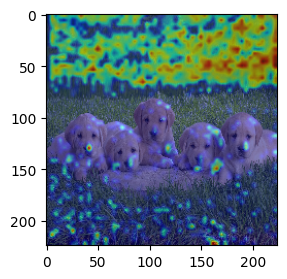

In [109]:
cam_backbone_c2f1 = virtualize_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f1"])

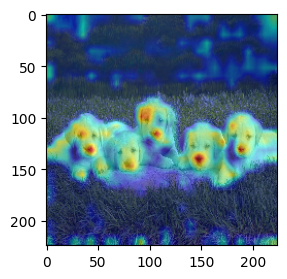

In [110]:
cam_backbone_c2f2 = virtualize_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f2"])

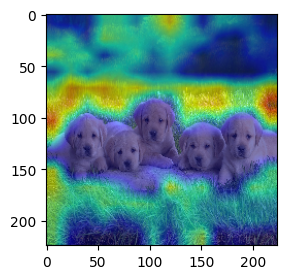

In [111]:
cam_backbone_c2f3 = virtualize_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f3"])

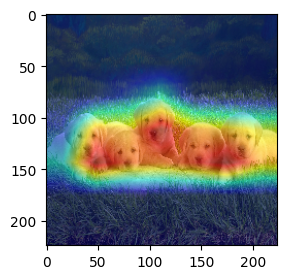

In [112]:
cam_backbone_c2f4 = virtualize_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f4"])

**评估指标:**

**ROAD(Region Of Attention Discirmination):** (有问题:`ClassifierOutputTarget(category=17)`这一部分意义不明)

- `ROADMostRelevantFirstAverage`: 逐步移除置信度从高到地的CAM区域,比较移除前后模型预测置信度的区别,相差越大,代表高相关区域定位准确.
- `ROADLeastRelevantFirstAverage`: 逐步移除置信度从低到高的CAM区域,比较移除前后模型预测置信度的区别,相差越小,代表无关区域没有被错误定位到.

In [113]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage

def eval_ROADMostRelevantFirst(model, input_tensor, grayscale_cams, target_classes) -> None:
    cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
    # all_layers is a dict, but target_layers must be list

    scores = cam_metric(
        model=model, input_tensor=input_tensor, cams=grayscale_cams, targets=target_classes,
    )
    # print(scores.size)
    score = scores.sum()
    print(f"The average confidence increase with ROAD accross 4 thresholds: {score}")


# You can also average across different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2

batch_cam_backbone_c2f1 = torch.from_numpy(cam_backbone_c2f1).unsqueeze(dim=0)

eval_ROADMostRelevantFirst(
    model=yolo.model, input_tensor=input_tensor, grayscale_cams=batch_cam_backbone_c2f1.numpy(), target_classes=[ClassifierOutputTarget(category=17)]
)

def eval_ROADLeastRelevantFirstAverage(model, input_tensor, grayscale_cams, target_classes) -> None:
    cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
    # all_layers is a dict, but target_layers must be list

    scores = cam_metric(
        model=model,
        input_tensor=input_tensor,
        cams=grayscale_cams,
        targets=target_classes,
    )
    # print(scores.size)
    score = scores.sum()
    print(f"The average confidence increase with ROAD accross 4 thresholds: {score}")


# You can also average across different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2

eval_ROADLeastRelevantFirstAverage(
    model=yolo.model,
    input_tensor=input_tensor,
    grayscale_cams=batch_cam_backbone_c2f1.numpy(),
    target_classes=[ClassifierOutputTarget(category=17)],
)

The average confidence increase with ROAD accross 4 thresholds: -0.004247870296239853
The average confidence increase with ROAD accross 4 thresholds: 0.001982684712857008


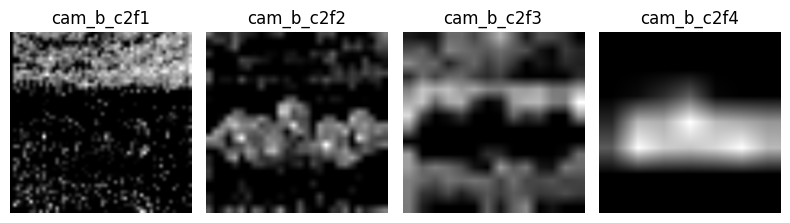

In [114]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))

axes[0].imshow(cam_backbone_c2f1, cmap="gray")
axes[0].set_title("cam_b_c2f1")
axes[0].axis("off")
axes[1].imshow(cam_backbone_c2f2, cmap="gray")
axes[1].set_title("cam_b_c2f2")
axes[1].axis("off")
axes[2].imshow(cam_backbone_c2f3, cmap="gray")
axes[2].set_title("cam_b_c2f3")
axes[2].axis("off")
axes[3].imshow(cam_backbone_c2f4, cmap="gray")
axes[3].set_title("cam_b_c2f4")
axes[3].axis("off")
plt.tight_layout()
plt.show()

**SSIM(Structural Similarity，结构相似性)**

通过比较原始样本和对抗样本的热力图, 衡量注意力区域是否被显著改变, SSIM 越低 → 热力图结构差异越大（攻击更有效）

In [124]:
from skimage.metrics import structural_similarity  

# im1, im2分别表示参与计算的图像数据
# data_range表示图像数据的范围，一般设置为255或者1(如果对图像数据做了归一化操作，则为1)
# channel_axis表示颜色通道位于图像的第几维度，如果不指定的话，则默认输入灰度图像
ssim = structural_similarity(
    cam_backbone_c2f1,
    cam_backbone_c2f4,
    win_size=None,
    gradient=False,
    data_range=1,
    channel_axis=None,
    multichannel=False,
    gaussian_weights=False,
    full=False,
)

print(f"SSIM of cam_backbone_c2f1 & cam_backbone_c2f2: {ssim}")

SSIM of cam_backbone_c2f1 & cam_backbone_c2f2: 0.046321419087832987


**Weight sum**